# Delivery Time Prediction & Feature Impact Analysis

**Objective:**    
Build **machine learning models** to predict food delivery time and validate insights from previous analysis, especially the impact of traffic conditions, order time, and festivals.

In [3]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.0 MB 13.0 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/8.0 MB 13.6 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.0 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 13.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---- ----------------------------------- 4.2/38.5 MB 19.6 MB/s eta 0:00:02
   -------- ------------------------------- 7.9/38.5 MB 19.2 MB/s eta 0:00:02
   ------------ --------------------------- 12.3/38.5 MB 19.5 MB/s eta 0:00:02
   ----------------- ---------------------- 16.8/38.5 MB 20.0 MB/s eta 0:00:02
   --------------------- ------------------ 20.7/38.5 MB 19.7 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [21]:
# Load dataset
df = pd.read_csv("../data/zomato_cleaned_features.csv")

features = ['Road_traffic_density', 'Weather_conditions', 'multiple_deliveries', 'Order_Hour', 'Festival']
target = 'Time_taken (min)'

df_model = df[features + [target]].dropna()
df_model['multiple_deliveries'] = df_model['multiple_deliveries'].astype(int)
df_model['Order_Hour'] = df_model['Order_Hour'].astype(int)

df_model.head().style.hide(axis="index")

Road_traffic_density,Weather_conditions,multiple_deliveries,Order_Hour,Festival,Time_taken (min)
Jam,Fog,3,21,No,46
High,Stormy,1,14,No,23
Medium,Sandstorms,1,17,No,21
Low,Sandstorms,0,9,No,20
Jam,Fog,1,19,No,41


In [11]:
# Preprocessing
cat_features = ['Road_traffic_density', 'Weather_conditions', 'Festival']
num_features = ['Order_Hour', 'Multiple_deliveries']

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

In [13]:
# Split dataset into Training and Testing sets
X = df_model[features]
y =df_model[target]

# training 80%, testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Linear Regression (Baseline Model)
lr_pipeline = Pipeline([('preprocess', preprocessor),('model', LinearRegression())])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr:.2f} minutes")

Linear Regression MAE: 5.88 minutes


**Interpretation**
- Linear Regression model predicts delivery time with an average error of about 5.88 minutes.  
- It's a simple baseline that's easy to understand, but it might not capture more complex patterns like traffic jams or festival effects.

In [17]:
# Random Forest (Compare Model)
rf_pipeline = Pipeline([('preprocess', preprocessor),('model', RandomForestRegressor(n_estimators=200, random_state=42))])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.2f} minutes")

Random Forest MAE: 5.39 minutes


**Interpretation**
- The Random Forest model predicts delivery time with an average error of about 5.39 minutes, which is lower than the Linear Regression model.
- This suggests that Random Forest can better capture more complex and non-linear patterns, such as traffic conditions and festival effects.
- So, Random Forest provides better accuracy than the baseline model, making it more suitable for this prediction task.

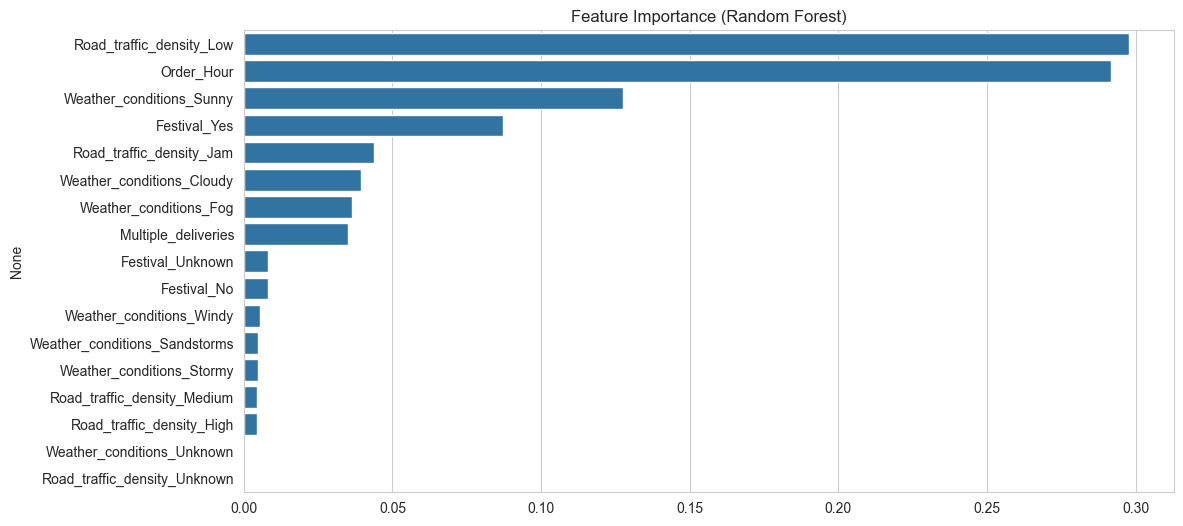

In [18]:
# Get feature names after one-hot encoding
ohe = rf_pipeline.named_steps['preprocess'].named_transformers_['cat']
ohe_features = list(ohe.get_feature_names_out(cat_features))
all_features = ohe_features + num_features

# Get feature importance
importances = rf_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

## Predictive Modeling — Summary
### Model Performance
- **Linear Regression MAE:** 5.88 minutes
- **Random Forest MAE:** 5.39 minutes
  
Random Forest performs better, indicating that delivery time is influenced by non-linear patterns that a simple linear model cannot fully capture.

### Key Features Impacting Delivery Time
1. **Road_traffic_density**: It is the most important factor and has a strong effect on how long deliveries take.
2. **Order_Hour**: The time of day matters a lot, especially during peak hours when traffic is heavier.
3. **Weather_conditions**: Weather has a moderate impact on delivery time, with bad weather causing slightly longer deliveries.
4. **Festival**: Deliveries during festival days tend to take a bit longer, likely because there are more orders.
5. **Multiple_deliveries**: It has less impact compared to traffic conditions and order time.